## Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Load packages, modules, data and functions

### Load libraries, packages and modules

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
plt.style.use('fivethirtyeight')

from scipy import stats
from scipy.stats import skew

### Load the two datasets and combine them
The relationship (family member, wife-husband, child-parent, etc.) among passengers is a potential influential factor for the survival rate. For its analysis, the data of all the passengers needs to put together. So the training data and the testing data will be combined.

In [87]:
#load train data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
#create a new column 'Is_train' to differentiate the training data from the testing data, 1 = training, 0 = testing
train_df['Is_train'] = 1
test_df['Is_train'] = 0
#create the 'Survived' column filled with null values in the testing data
#so as to share the same columns as the training data
test_df['Survived'] = np.nan
#combine the trainning data and testing data
full_df = pd.concat([train_df, test_df], ignore_index=True)
# delete the two dataframes which are no longer needed
del train_df, test_df
#show the first and last rows of the combined data
display(full_df.head())
full_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,0


In [88]:
#Get the total number of passengers in the full dataset
len(full_df)

1309

**Finding & analysis:**   
Our full data has 1309 records, one for each passenger. According to [WIKIPEDIA](https://en.wikipedia.org/wiki/Passengers_of_the_Titanic) and [HISTORY ON THE NET](https://www.historyonthenet.com/how-many-people-were-on-the-titanic), the total number of Titanic's passengers was 1,317 or 1316. So our full data covers 99% of the passenger population, with only 7 or 8 missing records.

### Fix some data errors and fill in a couple of missing age values

References:   
[Some SibSp/Parch values are wrong](https://www.kaggle.com/c/titanic/discussion/39787)   
[Miss Erna Alexandra Andersson](https://www.encyclopedia-titanica.org/titanic-survivor/erna-andersson.html)   
[Miss Ida Augusta Margareta Andersson](https://www.encyclopedia-titanica.org/titanic-victim/ida-augusta-margareta-andersson.html)

In [89]:
#fix the data errors according to 
#show the original records
indices = [279, 746, 1283, 987, 1188, 48, 920, 13, 610, 119, 541, 542, 813, 850, 68, 1105, 736, 436, 1058, 86, 147]
full_df.iloc[indices, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S,1
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.2500,NaN,S,1
1283,1284,NaN,3,"Abbott, Master. Eugene Joseph",male,13.0,0,2,C.A. 2673,20.2500,NaN,S,0
987,988,NaN,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,76.0,1,0,19877,78.8500,C46,S,0
1188,1189,NaN,3,"Samaan, Mr. Hanna",male,NaN,2,0,2662,21.6792,NaN,C,0
48,49,0.0,3,"Samaan, Mr. Youssef",male,NaN,2,0,2662,21.6792,NaN,C,1
920,921,NaN,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C,0
13,14,0.0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,1
610,611,0.0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,1
119,120,0.0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,1


In [90]:
#fix the errors and fill in the missing age values for the Sammann family
full_df.loc[279, ['SibSp', 'Parch']]= 0, 2
full_df.loc[1283, ['SibSp', 'Parch']] = 1, 1
full_df.loc[987, 'Age'] = 26
full_df.loc[1188, ['Age', 'SibSp', 'Parch']] = 40, 0, 2
full_df.loc[48, ['Age', 'SibSp', 'Parch']] = 16, 1, 1
full_df.loc[920, ['Age', 'SibSp', 'Parch']] = 18, 1, 1
full_df.loc[68, ['SibSp', 'Parch']] = 0, 0
full_df.loc[1105, ['SibSp', 'Parch']] = 0, 0
full_df.loc[736, ['SibSp', 'Parch']] = 0, 4
full_df.loc[[436, 1058, 86, 147], ['SibSp', 'Parch']] = 3, 1

In [91]:
#sanity check
full_df.iloc[indices, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,0,2,C.A. 2673,20.2500,NaN,S,1
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.2500,NaN,S,1
1283,1284,NaN,3,"Abbott, Master. Eugene Joseph",male,13.0,1,1,C.A. 2673,20.2500,NaN,S,0
987,988,NaN,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,26.0,1,0,19877,78.8500,C46,S,0
1188,1189,NaN,3,"Samaan, Mr. Hanna",male,40.0,0,2,2662,21.6792,NaN,C,0
48,49,0.0,3,"Samaan, Mr. Youssef",male,16.0,1,1,2662,21.6792,NaN,C,1
920,921,NaN,3,"Samaan, Mr. Elias",male,18.0,1,1,2662,21.6792,NaN,C,0
13,14,0.0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,1
610,611,0.0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,1
119,120,0.0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,1


**More errors were found in the following analysis:**  
[two wrong_fares](#wrong_fares)

### My functions

In [92]:
#visualization of data distribution of categorical variables
def plot_histogram(col_name, df=full_df, bins=None):
    plt.hist(df[col_name].dropna(), bins)
    plt.title('Distribution of {}'.format(col_name))
    plt.xlabel(col_name)
    plt.ylabel('Number')
    plt.show()

In [93]:
def compare_bars(col_name, df=full_df):
    df[df.Survived==1][col_name].dropna().\
    value_counts(normalize=False).plot(kind='bar', color='#008fd5', alpha=0.5, label='survived')
    df[df.Survived==0][col_name].dropna().\
    value_counts(normalize=False).plot(kind='bar', color='#fc4f30', alpha=0.5, label='not survived')
    plt.xticks(rotation=0)
    plt.title('Bar of {}'.format(col_name))
    plt.xlabel(col_name)
    plt.ylabel('Number')
    plt.legend(loc='upper right')
    plt.show()

In [94]:
def stack_bar(col_name, df=full_df):
    pd.crosstab(df[col_name], df['Survived']).plot(kind='bar', stacked=True, title='Survived by {}'.format(col_name))
    plt.xticks(rotation=0)
    pd.crosstab(df[col_name], df['Survived'], normalize='index').\
    plot(kind='bar', stacked=True,title='Survived by {} (%)'.format(col_name))
    plt.xticks(rotation=0)

In [95]:
def compare_hists(col_name, bins=None, df=full_df):
    plt.hist(df[df.Survived==1][col_name].dropna(), bins=bins, density=False, label='survived', alpha=0.5)
    plt.hist(df[df.Survived==0][col_name].dropna(), bins=bins, density=False, label='not survived',alpha=0.5)
    plt.title('Histograms of {}'.format(col_name))
    plt.xlabel(col_name)
    plt.ylabel('Number')
    plt.legend(loc='upper right')
    plt.show()

Univariate + One step ahead

## Understand the variables

### Overview
<a id='2.1'></a>

In [96]:
#overview (number of samples and columns, column names, data types, the number of null values)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1049 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Is_train     1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


In [97]:
isnull_sum = full_df.isnull().sum()
isnull_df = pd.concat([isnull_sum, round(isnull_sum/len(full_df)*100)], axis=1)
isnull_df.columns = ['Number', 'Percentage(%)']
isnull_df

,Number,Percentage(%)
PassengerId,0,0.0
Survived,418,32.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,260,20.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,1,0.0


**Finding:**  
Columns (except Survived) with many missing values: Age(260, 20%), Cabin(1014, 77%).  
Columns with a couple of  missing values: Fare(1), Embarked(2).  

In [98]:
#summary statistics (check data scales and any signs of incorrect values or outliers)
full_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Is_train
count,1309.000000,891.000000,1309.000000,1049.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.818561,0.492743,0.381971,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.337059,1.037221,0.861607,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


In [99]:
print('Number of zero-fare tickets:', sum(full_df.Fare==0))

Number of zero-fare tickets: 17


In [100]:
full_df[full_df.Fare==0].sort_values(by='Pclass')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
1263,1264,NaN,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0,B52 B54 B56,S,0
263,264,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,1
822,823,0.0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,NaN,S,1
815,816,0.0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0,B102,S,1
1157,1158,NaN,1,"Chisholm, Mr. Roderick Robert Crispin",male,NaN,0,0,112051,0.0,NaN,S,0
633,634,0.0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,1
806,807,0.0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S,1
277,278,0.0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,1
413,414,0.0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,1
466,467,0.0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,1


**Finding & analysis on the summary statistics:**

The data scales of Age and Fare are much bigger than those of the rest numerical variables. The machine-learnig algorithms based on the distance measurements or gradient descent are quite sensitive to the scales, so rescaling is necessary. For tree-based algorithms, scaling is not necessary.

The minimum fare is zero, involving 17 tickets.It may indicate free tickets or missing values. [Tammy]( https://www.kaggle.com/c/titanic/discussion/10570) found the evidence about the complimentary ticket for John George. As not any evidence was found about the missing fare data marked as 0, I interpreted the value 0 as it is (free ticket).  

The maximum fare is 512, much higher than the median. Are there any outliers? It will be further analyzed in [Data distribution of numerical variables](#Data-distribution-of-numerical-variables)

In [101]:
#check the number of unique values of each columns
unique_counts = pd.DataFrame.from_records([(col, full_df[col].nunique()) for col in full_df.columns], columns=['Column_Name', 'Num_Unique']).\
                sort_values(by='Num_Unique')
unique_counts

,Column_Name,Num_Unique
1,Survived,2
4,Sex,2
12,Is_train,2
2,Pclass,3
11,Embarked,3
6,SibSp,7
7,Parch,8
5,Age,97
10,Cabin,186
9,Fare,281


**Finding:**  
Some categorical variables have 2 or 3 uniuqe values - 'Survived', 'Sex', 'Pclass', 'Embarked'.  
The other categorial variables have over 100 unique values - 'Cabin', 'Ticket', 'PassengerId', 'Name'. Not all the ticket numbers or cabin numbers are unique. It will be further analyzed in [Fare sharing?](#Fare-sharing?) and [Further analysis of 'Cabin' and 'Ticket'](#Further-analysis-of-'Cabin'-and-'Ticket').

### Data distribution of numerical variables

In [102]:
#list the names of the numerical variables
cols_num = ['Age', 'SibSp', 'Parch', 'Fare']

In [103]:
for col in cols_num:
    skewness = skew(full_df[col].dropna())
    print('Skewness of {}: {}'.format(col, round(skewness,1)))

Skewness of Age: 0.4
Skewness of SibSp: 3.9
Skewness of Parch: 3.7
Skewness of Fare: 4.4


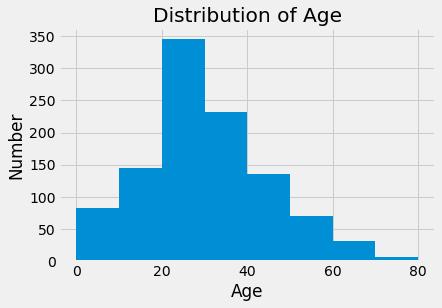

In [104]:
#check the distribution of numerical variables
plot_histogram('Age', bins=np.arange(0, 90, 10))

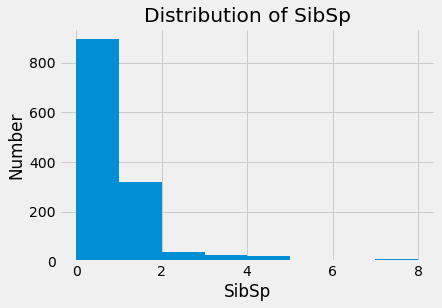

In [105]:
plot_histogram('SibSp', bins=np.arange(0,9,1))

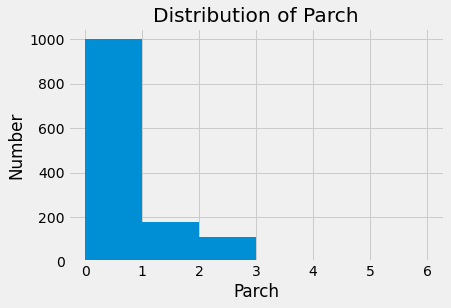

In [106]:
plot_histogram('Parch', bins=np.arange(0, 7, 1))

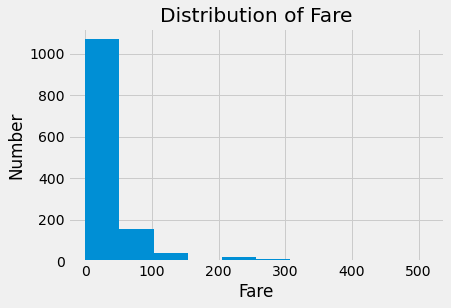

In [107]:
plot_histogram('Fare')

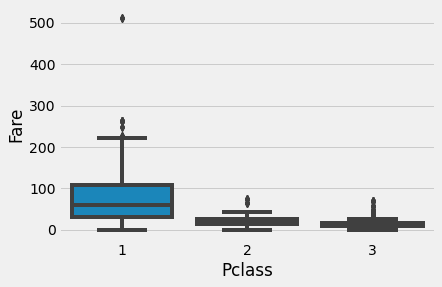

In [108]:
sns.boxplot(x='Pclass', y='Fare', data=full_df);

In [109]:
#obtain descriptive statistics of fares at different pclasses
fares_by_pclasses = {}
for i in range(1,4):
    fares_by_pclasses[i]=full_df.loc[full_df.Pclass==i, 'Fare'].describe()
    
fares_by_pclasses_df = pd.concat([v[1] for v in fares_by_pclasses.items()], axis=1)
fares_by_pclasses_df.columns=['Pclass ' + str(i) for i in range(1, 4)]
print("Fares' distribution in each Pclass:")
display(fares_by_pclasses_df)

Fares' distribution in each Pclass:


,Pclass 1,Pclass 2,Pclass 3
count,323.000000,277.000000,708.000000
mean,87.508992,21.179196,13.302889
std,80.447178,13.607122,11.494358
min,0.000000,0.000000,0.000000
25%,30.695800,13.000000,7.750000
50%,60.000000,15.045800,8.050000
75%,107.662500,26.000000,15.245800
max,512.329200,73.500000,69.550000


**Analysis on the distribution of numerical variables:**

'Age': relatively normal.  
'Sibsp', 'Parch', 'Fare': not normal, right skewed. Replace them with their log, square root or inverse values may help remove the skewness and minimize the extreme values' impact on the algorithms.  


Usually, the fares are much related with the classes. It's true for this case, as confirmed by the correlation analysis in the section [Correlation between variables](#Correlation-between-variables). According to the boxplot and descriptive statistics, the fare median increases a lot (8->15->60) when the Pclass value decreases (3->2->1).  
However, it's unusual that the fares vary so much in each class (max/median 5~9) that there's considerable overlap between the fares of different classes. It's further analyzed in the the section [Fare_sharing?](#Fare-sharing?)

### Data distribution of categorical variables

In [110]:
#List the names of the categorical columns which have fewer than 10 categories
cols_few_cat = ['Survived', 'Pclass', 'Sex', 'Embarked']
#List the names of the categorical columns which have more than 10 categories but fewer than 891 categories
cols_many_cat= ['Ticket', 'Cabin']

#### Categorical columns which have only a few categories

In [111]:
#List the value_counts of the categorical columns which have only a few categories
for col in cols_few_cat:
    print('Column Name:', col)
    print(full_df[col].value_counts(normalize=True))
    print('')

Column Name: Survived
0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64

Column Name: Pclass
3    0.541635
1    0.246753
2    0.211612
Name: Pclass, dtype: float64

Column Name: Sex
male      0.644003
female    0.355997
Name: Sex, dtype: float64

Column Name: Embarked
S    0.699311
C    0.206580
Q    0.094109
Name: Embarked, dtype: float64



#### Categorical columns which have many categories

In [112]:
#check for duplicated values, this 'value' means the number of samples sharing the same value, 
for col in cols_many_cat:
    value_counts = full_df[col].value_counts()
    duplicated_value_counts = value_counts.value_counts()
    duplicated_value_counts_df = duplicated_value_counts.to_frame()
    duplicated_value_counts_df.reset_index(inplace=True)
    duplicated_value_counts_df.rename(columns={'index': 'number of duplicated samples per uniuqe value', col: 'number of unique values'}, \
                                     inplace=True)
    print('Duplicated value counts of {}'.format(col))
    print(duplicated_value_counts_df)
    print('')

Duplicated value counts of Ticket
   number of duplicated samples per uniuqe value  number of unique values
0                                              1                      713
1                                              2                      132
2                                              3                       49
3                                              4                       16
4                                              5                        7
5                                              7                        5
6                                              6                        4
7                                              8                        2
8                                             11                        1

Duplicated value counts of Cabin
   number of duplicated samples per uniuqe value  number of unique values
0                                              1                      107
1                                           

In [113]:
ticket_count  = full_df.Ticket.value_counts()
shared_tickets = list(ticket_count[ticket_count>1].index)
#I checked the first 30 records totally, 5 of them are shown here
full_df[full_df.Ticket.isin(shared_tickets)].sort_values(by='Ticket').head() 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
257,258,1.0,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.50,B77,S,1
504,505,1.0,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.50,B79,S,1
759,760,1.0,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.50,B77,S,1
558,559,1.0,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.65,E67,S,1
262,263,0.0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.65,E67,S,1


In [114]:
#I checked the first 30 records totally, 5 of them are shown here
full_df[full_df.Ticket.isin(shared_tickets)&(full_df.Pclass==3)].sort_values(by='Ticket').head() 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
74,75,1.0,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,1
509,510,1.0,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,1
838,839,1.0,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,1
826,827,0.0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,1
169,170,0.0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S,1


#### Fare sharing? 

On [encyclopedia-titanic](https://www.encyclopedia-titanica.org/), I found that the passengers sharing the ticket numbers are sharing the ticket fares as well, which means that the fare is actually the total fare for them.To double check, I plot the data.

In [115]:
#group the records by ticket numbers and count each groups
ticket_group_sizes = full_df.groupby('Ticket').size()

#create a new feature 'Ticket_group_size'    
full_df['Ticket_group_size'] = full_df['Ticket'].apply(lambda x: ticket_group_sizes[x])

In [116]:
#check whether the fare values within each ticket group are consistent
are_fares_different = full_df.groupby('Ticket').Fare.nunique() > 1
are_fares_different[are_fares_different].index.tolist()

['7534']

In [117]:
full_df[full_df['Ticket']=='7534']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
138,139,0.0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S,1,2
876,877,0.0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S,1,2


**Finding:**  
The two fare values of ticket '7534' are only slightly different (9.2167, 9.8458).  
On [encyclopedia-titanic](https://www.encyclopedia-titanica.org/), it's not mentioned that they had any companion on board. 

In [118]:
ticket_group_sizes = full_df['Ticket_group_size'].value_counts()
ticket_group_percentages = round(full_df['Ticket_group_size'].value_counts()/len(full_df)*100)

In [119]:
ticket_groups = pd.concat([ticket_group_sizes, ticket_group_percentages], axis=1)
ticket_groups.columns = ['Quantity', 'Percentage']
ticket_groups

,Quantity,Percentage
1,713,54.0
2,264,20.0
3,147,11.0
4,64,5.0
7,35,3.0
5,35,3.0
6,24,2.0
8,16,1.0
11,11,1.0


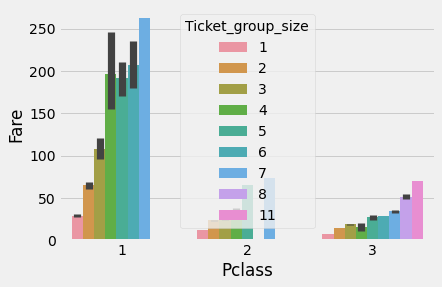

In [120]:
sns.barplot(x='Pclass', y='Fare', hue='Ticket_group_size', data=full_df);

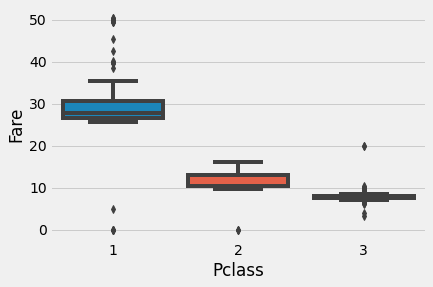

In [121]:
tickets_not_shared = full_df[full_df['Ticket_group_size']==1]
sns.boxplot(x='Pclass', y='Fare', data=tickets_not_shared);

**Finding and analyzing the outliers of the fFares:**   
In the section [Overview](#Overview), it's already mentioned that some tickets were complimentary (fare value=0).
For Pclass 1, one ticket's fare was very low, around 5. For Pclass 1 and Pclass 3, the maximum fares nearly doubles the median. Whether these values are correct, will be further analyzed next.

In [122]:
#Locate the record of very cheap Pclass1 ticket 
tickets_not_shared[(tickets_not_shared.Pclass==1) & (tickets_not_shared.Fare.isin(range(1,10)))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
872,873,0.0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0,B51 B53 B55,S,1,1


**Search online about the ticket fare of Mr. Frans:**   
According to [Geni](https://www.geni.com/people/Frans-Olof-Carlsson-1st-Class-RMS-Titanic-Casualty/6000000015948569078), Mr. Frans' ticket fare was indeed  £5. 

In [123]:
#Locate the records of very expensive Pclass1 tickets
tickets_not_shared[(tickets_not_shared.Pclass==1) & (tickets_not_shared.Fare > 50)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
867,868,0.0,1,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S,1,1
1057,1058,NaN,1,"Brandeis, Mr. Emil",male,48.0,0,0,PC 17591,50.4958,B10,C,0,1


**Search online about the ticket fare of Mr. Washington:**  
As [Encyclopedia-titanica](https://www.encyclopedia-titanica.org/titanic-victim/washington-roebling.html) mentions, Mr. Washington carried ticket no. PC 17590 (£50 9s 11d). So the fare was confirmed.  

In [124]:
tickets_not_shared[(tickets_not_shared.Pclass==3) & (tickets_not_shared.Fare > 15)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
451,452,0.0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,19.9667,NaN,S,1,1
490,491,0.0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,19.9667,NaN,S,1,1


**Search online about the ticket fares of Mr. Ingvald and Mr. Konrad**   
As [Encyclopedia-titanica ](https://www.encyclopedia-titanica.org/titanic-victim/ingvald-olai-olsen-hagland.html) mentions, Mr. Ingvald was the brother in law of Mr. Konrad and their ticket fares were £6, 19s, 4d, within the normal fare range of Pclass 3. So their fare values in our data are wrong and should be 6.9667.
<a id="wrong_fares"></a>

In [125]:
#Correct the two wrong fare values
full_df.loc[[451, 490], 'Fare'] = 6.9667
full_df.iloc[[451, 490]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size
451,452,0.0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,6.9667,NaN,S,1,1
490,491,0.0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,6.9667,NaN,S,1,1


**Finding and analysis on fare-sharing:**   
Almost half of the passengers share the ticket numbers with some other(s). Most of the ticket groups have 2 or 3 persons.The biggest group has 11 people.In each group,their fare values are the same, with only one exception that the two fare values of ticket '7534' are slightly different (9.22, 9.84).  

In each of the Pclasses, the fares tend to increase with the ticket group sizes.So it confirms that the members of a ticket group share the ticket fare. Among the passengers who did not share the ticket numbers, their fare ranges of different Pclasses rarely overlap.
Due to the high percentages of fare sharing, the direct comparison of the fare values among different samples can be misleading.   

However, we don't know how they split the fare for the share may vary with the individual's travelling distance and the age. It will be further analyzed next.

In [163]:
#Look for different embarked values within each ticket-sharing group
are_embarked_different  = full_df.groupby('Ticket').Embarked.nunique() >1
are_embarked_different[are_embarked_different].index.tolist()

['113798', 'PC 17760']

In [166]:
full_df.loc[full_df['Ticket'].isin(['113798', 'PC 17760']), :'Embarked'].sort_values(by='Ticket')

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
270,271,0.0,1,"Cairns, Mr. Alexander",NaN,0,0,113798,31.0000,NaN,S
842,843,1.0,1,"Serepeca, Miss. Augusta",30.0,0,0,113798,31.0000,NaN,C
269,270,1.0,1,"Bissette, Miss. Amelia",35.0,0,0,PC 17760,135.6333,C99,S
325,326,1.0,1,"Young, Miss. Marie Grice",36.0,0,0,PC 17760,135.6333,C32,C
373,374,0.0,1,"Ringhini, Mr. Sante",22.0,0,0,PC 17760,135.6333,NaN,C
1205,1206,NaN,1,"White, Mrs. John Stuart (Ella Holmes)",55.0,0,0,PC 17760,135.6333,C32,C


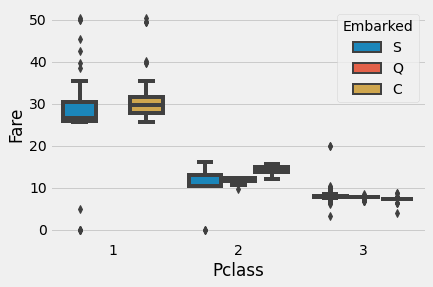

In [167]:
sns.boxplot(x='Pclass', hue='Embarked', y='Fare', data=tickets_not_shared);

In [171]:
tickets_not_shared.groupby(['Pclass', 'Embarked']).Fare.median()

Pclass  Embarked
1       C           29.7000
        S           26.5500
2       C           13.8625
        Q           12.3500
        S           13.0000
3       C            7.2292
        Q            7.7500
        S            7.8958
Name: Fare, dtype: float64

**Finding:**   
The fares does not vary much within each Pclass and the median fare values' differences are around 10%.

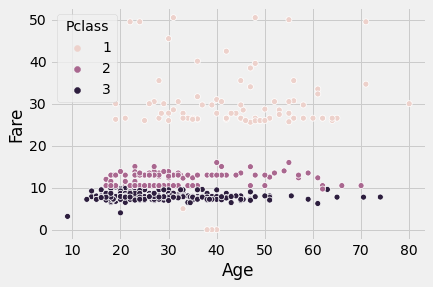

In [199]:
tickets_not_shared_nonull = tickets_not_shared.dropna(subset=['Age', 'Fare'])
pclass_values = tickets_not_shared_nonull.Pclass.tolist()
ax = sns.scatterplot(x='Age', y='Fare', hue=pclass_values, data=tickets_not_shared_nonull, legend='full');
ax.legend(title='Pclass');

**Finding:**   
As the graph shows, there's no obvious correlation between fare and age within each Pclass.
However, we can't jump to the conclusion that the fare is the same for all the ages because these analyzed records only involve the ages near 10 or above.
In our common sense, no fee is charged to the infant.

In [206]:
full_df.sort_values(by='Pclass').loc[full_df.Age<1, :'Embarked']

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
305,306,1.0,1,"Allison, Master. Hudson Trevor",0.92,1,2,113781,151.5500,C22 C26,S
831,832,1.0,2,"Richards, Master. George Sibley",0.83,1,1,29106,18.7500,NaN,S
755,756,1.0,2,"Hamalainen, Master. Viljo",0.67,1,1,250649,14.5000,NaN,S
1141,1142,NaN,2,"West, Miss. Barbara J",0.92,1,2,C.A. 34651,27.7500,NaN,S
78,79,1.0,2,"Caldwell, Master. Alden Gates",0.83,0,2,248738,29.0000,NaN,S
1245,1246,NaN,3,"Dean, Miss. Elizabeth Gladys Millvina""""",0.17,1,2,C.A. 2315,20.5750,NaN,S
1172,1173,NaN,3,"Peacock, Master. Alfred Edward",0.75,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S
1092,1093,NaN,3,"Danbom, Master. Gilbert Sigvard Emanuel",0.33,0,2,347080,14.4000,NaN,S
1198,1199,NaN,3,"Aks, Master. Philip Frank",0.83,0,1,392091,9.3500,NaN,S
644,645,1.0,3,"Baclini, Miss. Eugenie",0.75,2,1,2666,19.2583,NaN,C


In [ ]:
#Compare Fare_mean between the group with infant(s) and without infant

In [211]:
full_df.sort_values(by='Pclass').loc[full_df.Age<1, :'Fare_mean']

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size,Fare_mean
305,306,1.0,1,"Allison, Master. Hudson Trevor",0.92,1,2,113781,151.5500,C22 C26,S,1,6,25.258333
831,832,1.0,2,"Richards, Master. George Sibley",0.83,1,1,29106,18.7500,NaN,S,1,3,6.250000
755,756,1.0,2,"Hamalainen, Master. Viljo",0.67,1,1,250649,14.5000,NaN,S,1,2,7.250000
1141,1142,NaN,2,"West, Miss. Barbara J",0.92,1,2,C.A. 34651,27.7500,NaN,S,0,4,6.937500
78,79,1.0,2,"Caldwell, Master. Alden Gates",0.83,0,2,248738,29.0000,NaN,S,1,3,9.666667
1245,1246,NaN,3,"Dean, Miss. Elizabeth Gladys Millvina""""",0.17,1,2,C.A. 2315,20.5750,NaN,S,0,4,5.143750
1172,1173,NaN,3,"Peacock, Master. Alfred Edward",0.75,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,0,3,4.591667
1092,1093,NaN,3,"Danbom, Master. Gilbert Sigvard Emanuel",0.33,0,2,347080,14.4000,NaN,S,0,3,4.800000
1198,1199,NaN,3,"Aks, Master. Philip Frank",0.83,0,1,392091,9.3500,NaN,S,0,2,4.675000
644,645,1.0,3,"Baclini, Miss. Eugenie",0.75,2,1,2666,19.2583,NaN,C,1,4,4.814575


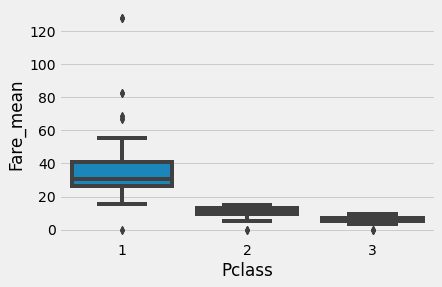

In [126]:
full_df['Fare_mean'] = full_df['Fare']/full_df['Ticket_group_size']
sns.boxplot(x='Pclass', y='Fare_mean', data=full_df[full_df['Ticket_group_size']!=1]);

In [ ]:
full_

**Finding and analysis of categorical variables and fare-sharing:**  
The number of the survivors is only half of that of the victims. So this is an imbalanced classfication task.  
The istributions of 'Pclass', 'Sex', 'Embarked' are also imbalanced.

'Cabin' and 'Ticket' have several hundreds of categories. Many of them only appear in one sample record.Some cabins accomodated more than one passengers. It makes sense. However, it's a bit suprising that some passengers are sharing the same 'Ticket' number and the same Fare. Of the 60 records I checked, according to the names and [encyclopedia-titanic](https://www.encyclopedia-titanica.org/), the ticket-sharing passengers may be somehow related (family members, employer & maid & valet, colleagues).The fare values of their records is the total value of all of them. So their fare values are much higher than the others.

### Check the relationship between Survived and other variables

#### Check how survival rates vary with the numerical variables

In [127]:
#Compare the variation of variable values (median) by Survived
pd.pivot_table(full_df, index='Survived', values=cols_num, aggfunc=np.median)

,Age,Fare,Parch,SibSp
Survived,,,,
0.0,28.0,10.5,0,0
1.0,28.0,26.0,0,0


In [128]:
pd.pivot_table(full_df[full_df.Ticket_group_size==1], index='Survived', \
               values=['Fare'], aggfunc=np.median)

,Fare
Survived,
0.0,7.925
1.0,10.500


**Finding:**  
The median values of these numerical variables do not vary by Survived, except for Fare.

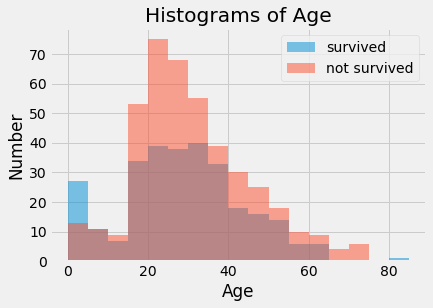

In [129]:
compare_hists('Age', bins=np.arange(0, 90, 5))

**Finding:**  
The group of age below 5 has much higher survival rates than the rest.  
Above 65, there are barely any survivors.

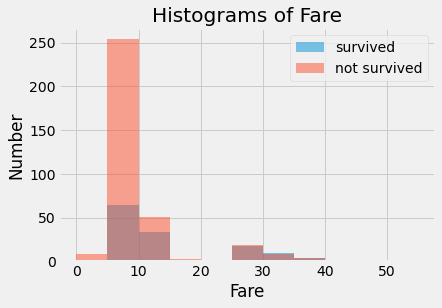

In [130]:
#As analyzed earlier, half of the passengers shared the fares with some other(s)
#So only the non-sharing records are selected for the comparison
compare_hists('Fare', bins=range(0, 60, 5),df=full_df[full_df.Ticket_group_size==1])

**Finding:**  
The survival rates at fares above 20 are much higher.

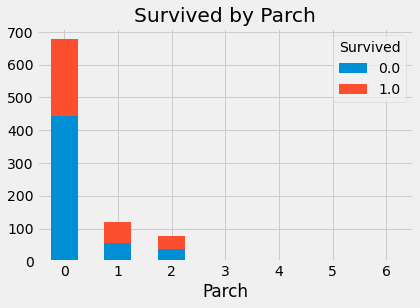

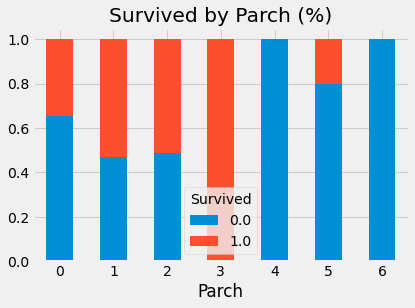

In [131]:
stack_bar('Parch')

**Finding:**  
The survival rates at Parch values f 1 and 2 are much higher than that at Parch value 0.

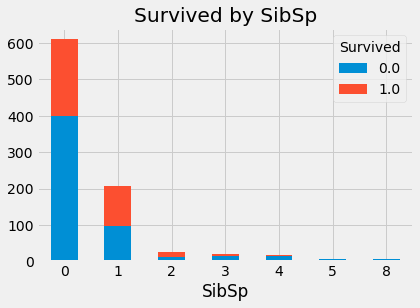

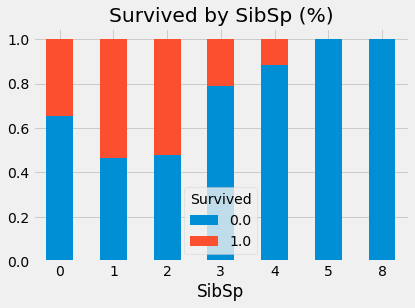

In [132]:
stack_bar('SibSp')

**Finding:**  
The survival rate at SibSp value of 1 is much higher than that at SibSp value 0.

#### Check how survival rates vary with the categorical variables

In [133]:
#Check the categorical variables with only a few unique values
for col in cols_few_cat[1:]:
    table = pd.pivot_table(full_df, index='Survived', columns=col, values='PassengerId', aggfunc='count', margins=True)
    #print('Count:')
    #print(table)
    #print('')
    print('Survival rates (%) varied by {}:'.format(col))
    display(round(100*table.iloc[[1], :-1].div(table.iloc[-1, :-1], axis=1)))
    print('')

Survival rates (%) varied by Pclass:


Pclass,1,2,3
Survived,,,
1.0,63.0,47.0,24.0



Survival rates (%) varied by Sex:


Sex,female,male
Survived,,
1.0,74.0,19.0



Survival rates (%) varied by Embarked:


Embarked,C,Q,S
Survived,,,
1.0,55.0,39.0,34.0


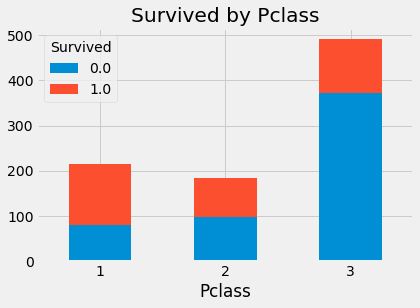

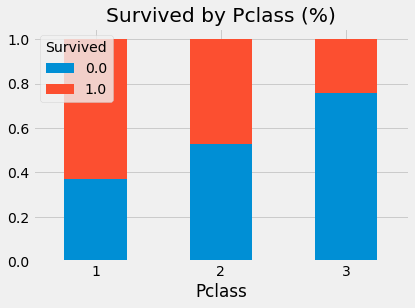

In [134]:
stack_bar('Pclass')

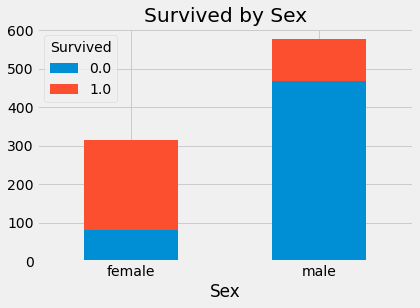

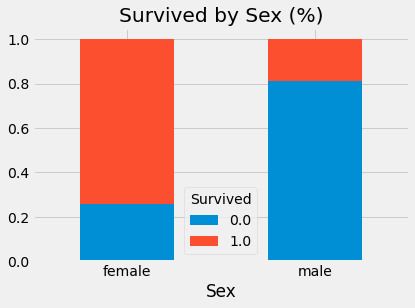

In [135]:
stack_bar('Sex')

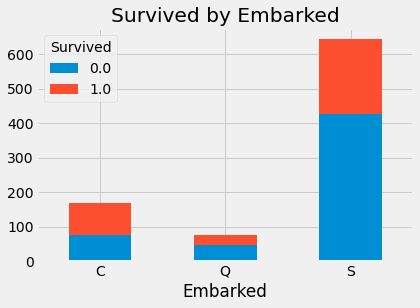

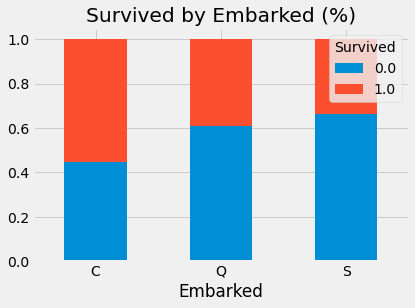

In [136]:
stack_bar('Embarked')

**Finding:**  
Pclass is related with the survival rate. Pclass 1 > Pclass 2 > Pclass 3.
Sex is very much related with the survival rate. The female' survival rate is more than 3 times as high survial rate as the male.
As for Embarked, the survival rate of Q is much higher than S and C.

#### Correlation between variables
According to [Pearson Product-Moment Correlation](https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide-2.php) and [Spearman's Rank-Order Correlation](https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide-2.php) from Laerd website:   
Pearson Product-Moment Correlation is between two interval or ratio variables which are normally distributed.As all variables but 'Age' fail to meet this requirement, this method is not appliable.  
Instead, Spearman Rank-Order Correlation method is applicable here for it only requires the variables to be either ordinal, interval or ratio. This method measures the strength and direction of the monotonic relationship between two ranked variables.

In [137]:
#map the sex values to 0 and 1, and create a new column 'Is_female'
full_df['Is_female'] = full_df['Sex'].map({'female': 1, 'male': 0})
full_df.drop('Sex',axis=1,inplace=True)
features = ['Survived', 'Pclass', 'Is_female', 'Age', 'SibSp', 'Parch', 'Fare']
corr_spearman = full_df[features].corr(method='spearman')['Survived']
corr_spearman

Survived     1.000000
Pclass      -0.339668
Is_female    0.543351
Age         -0.051146
SibSp        0.084307
Parch        0.135611
Fare         0.326285
Name: Survived, dtype: float64

,Survived,Pclass,Is_female,Age,SibSp,Parch,Fare
Survived,1.00,-0.34,0.54,-0.05,0.08,0.14,0.33
Pclass,-0.34,1.00,-0.12,-0.39,-0.07,-0.03,-0.71
Is_female,0.54,-0.12,1.00,-0.06,0.17,0.24,0.24
Age,-0.05,-0.39,-0.06,1.00,-0.14,-0.21,0.19
SibSp,0.08,-0.07,0.17,-0.14,1.00,0.43,0.45
Parch,0.14,-0.03,0.24,-0.21,0.43,1.00,0.41
Fare,0.33,-0.71,0.24,0.19,0.45,0.41,1.00


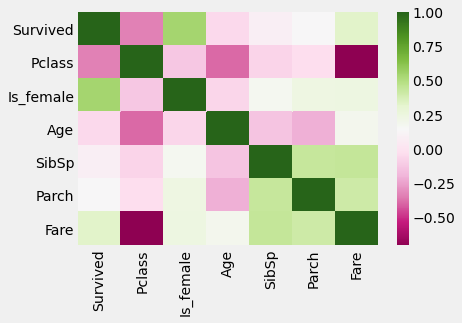

In [138]:
#use heatmap for visualization and choose contrast colors for a more clear view
display(round(full_df[features].corr(method='spearman'), 2))
sns.heatmap(full_df[features].corr(method='spearman'), cmap="PiYG");

In [139]:
#check the correlation between Fare and Pclass after removing the records containing the shared ticket numbers
round(tickets_not_shared[['Fare', 'Pclass']].corr(method='spearman').iloc[0,1], 2)

-0.77

**Finding and analysis**  
The top 3 most related variables for Survived: Is_female (0.54), Pclass (-0.33), Fare (0.32).
Among these three, Pclass and Fare are highly correlated (-0.69).Excluding the records containing the shared ticket values, their correlation got stronger (-0.77).  
Among all the variables, Age has the most weak correlation with Survived (-0.05), indicating very weak monotonic relationship.This doesn't necessarily mean that there's no relationship between 'Age' and 'Survived'. The above analysis shows that the children have a much higher survival rates and the elderly have a much a lower survival rates.

### Further analysis of 'Cabin' and 'Ticket'

In [140]:
#check the unique values of Cabin column
full_df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [141]:
round(full_df.loc[pd.notnull(full_df.Cabin), 'Survived'].mean(),2)

0.67

In [142]:
unique_cabin_values = full_df.Cabin.dropna().unique()
digit_only_values = []
alpha_only_values = []
long_values = [] #the cabin values of which the length is more than 4
other_values = []
for v in unique_cabin_values:
    if v.isdigit():
        digit_only_values.append(v)
    elif v.isalpha():
        alpha_only_values.append(v)
    elif len(v)>4:
        long_values.append(v)
    else:
        other_values.append(v)        

In [143]:
print('Different formats of Cabin values were found:\n')
print('Alpha-only values: {}\n'.format(alpha_only_values))
print('Long values: {}\n'.format(long_values))
print('Other values: {}\n'.format(other_values))

Different formats of Cabin values were found:

Alpha-only values: ['D', 'T', 'F']

Long values: ['C23 C25 C27', 'F G73', 'D10 D12', 'B58 B60', 'F E69', 'C22 C26', 'B57 B59 B63 B66', 'B96 B98', 'B51 B53 B55', 'F G63', 'C62 C64', 'B82 B84', 'C55 C57', 'F E46', 'F E57', 'E39 E41', 'B52 B54 B56']

Other values: ['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'E31', 'A5', 'D26', 'C110', 'E101', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'C106', 'C65', 'E36', 'C54', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'C128', 'D37', 'B35', 'E50', 'C82', 'E10', 'E44', 'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B5

In [144]:
display(full_df[full_df.Cabin.isin(['B61', 'B57 B59 B63 B66'])])

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size,Fare_mean,Is_female
311,312,1.0,1,"Ryerson, Miss. Emily Borie",18.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C,1,7,37.482143,1
742,743,1.0,1,"Ryerson, Miss. Susan Parker ""Suzette""",21.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C,1,7,37.482143,1
915,916,NaN,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",48.0,1,3,PC 17608,262.375,B57 B59 B63 B66,C,0,7,37.482143,1
950,951,NaN,1,"Chaudanson, Miss. Victorine",36.0,0,0,PC 17608,262.375,B61,C,0,7,37.482143,1
955,956,NaN,1,"Ryerson, Master. John Borie",13.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C,0,7,37.482143,0
1033,1034,NaN,1,"Ryerson, Mr. Arthur Larned",61.0,1,3,PC 17608,262.375,B57 B59 B63 B66,C,0,7,37.482143,0


<AxesSubplot:>

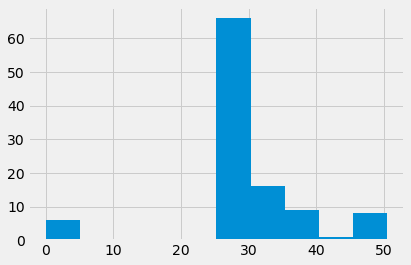

In [145]:
full_df.loc[(full_df.Ticket_group_size==1) & (full_df.Pclass==1), 'Fare'].hist()

In [146]:
other_values.sort()
other_values

['A10',
 'A11',
 'A14',
 'A16',
 'A18',
 'A19',
 'A20',
 'A21',
 'A23',
 'A24',
 'A26',
 'A29',
 'A31',
 'A32',
 'A34',
 'A36',
 'A5',
 'A6',
 'A7',
 'A9',
 'B10',
 'B101',
 'B102',
 'B11',
 'B18',
 'B19',
 'B20',
 'B22',
 'B24',
 'B26',
 'B28',
 'B3',
 'B30',
 'B35',
 'B36',
 'B37',
 'B38',
 'B39',
 'B4',
 'B41',
 'B42',
 'B45',
 'B49',
 'B5',
 'B50',
 'B61',
 'B69',
 'B71',
 'B73',
 'B77',
 'B78',
 'B79',
 'B80',
 'B86',
 'B94',
 'C101',
 'C103',
 'C104',
 'C105',
 'C106',
 'C110',
 'C111',
 'C116',
 'C118',
 'C123',
 'C124',
 'C125',
 'C126',
 'C128',
 'C130',
 'C132',
 'C148',
 'C2',
 'C28',
 'C30',
 'C31',
 'C32',
 'C39',
 'C45',
 'C46',
 'C47',
 'C49',
 'C50',
 'C51',
 'C52',
 'C53',
 'C54',
 'C6',
 'C65',
 'C68',
 'C7',
 'C70',
 'C78',
 'C80',
 'C82',
 'C83',
 'C85',
 'C86',
 'C87',
 'C89',
 'C90',
 'C91',
 'C92',
 'C93',
 'C95',
 'C97',
 'C99',
 'D11',
 'D15',
 'D17',
 'D19',
 'D20',
 'D21',
 'D22',
 'D26',
 'D28',
 'D30',
 'D33',
 'D34',
 'D35',
 'D36',
 'D37',
 'D38',
 'D40',

In [147]:
full_df['Cabin_quantity'] = 1
four_cabins = ['B57 B59 B63 B66']
three_cabins = ['C23 C25 C27', 'B51 B53 B55', 'B52 B54 B56']
two_cabins = ['D10 D12', 'B58 B60', 'C22 C26', 'B96 B98', 'C62 C64', 'B82 B84', 'C55 C57', 'E39 E41']
full_df.loc[full_df.Cabin.isin(four_cabins), 'Cabin_quantity']=4
full_df.loc[full_df.Cabin.isin(three_cabins), 'Cabin_quantity']=3
full_df.loc[full_df.Cabin.isin(two_cabins), 'Cabin_quantity']=2

In [148]:
full_df[full_df.Cabin_quantity>1].sort_values(by='Ticket')

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Ticket_group_size,Fare_mean,Is_female,Cabin_quantity
1263,1264,NaN,1,"Ismay, Mr. Joseph Bruce",49.00,0,0,112058,0.0000,B52 B54 B56,S,0,2,0.000000,0,3
802,803,1.0,1,"Carter, Master. William Thornton II",11.00,1,2,113760,120.0000,B96 B98,S,1,4,30.000000,0,2
435,436,1.0,1,"Carter, Miss. Lucile Polk",14.00,1,2,113760,120.0000,B96 B98,S,1,4,30.000000,1,2
390,391,1.0,1,"Carter, Mr. William Ernest",36.00,1,2,113760,120.0000,B96 B98,S,1,4,30.000000,0,2
763,764,1.0,1,"Carter, Mrs. William Ernest (Lucile Polk)",36.00,1,2,113760,120.0000,B96 B98,S,1,4,30.000000,1,2
305,306,1.0,1,"Allison, Master. Hudson Trevor",0.92,1,2,113781,151.5500,C22 C26,S,1,6,25.258333,0,2
1197,1198,NaN,1,"Allison, Mr. Hudson Joshua Creighton",30.00,1,2,113781,151.5500,C22 C26,S,0,6,25.258333,0,2
498,499,0.0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.00,1,2,113781,151.5500,C22 C26,S,1,6,25.258333,1,2
297,298,0.0,1,"Allison, Miss. Helen Loraine",2.00,1,2,113781,151.5500,C22 C26,S,1,6,25.258333,1,2
1262,1263,NaN,1,"Wilson, Miss. Helen Alice",31.00,0,0,16966,134.5000,E39 E41,C,0,5,26.900000,1,2


**Finding and analysis of Cabin**
1. Four formats of Cabin values  
All the 'Cabin' values start with a letter.    
Of the majority of uniuqe values, the letter is followed by a 1~3 digits.  
Of a few uniuqe Cabin values, they consist of the values of several single cabins.   
Of several uniuqe values, they consist of a letter and a cabin value.  
Only two unique values include nothing but a letter.  
     
2. Letter indicates deck  
The letter of 'Cabin' value is the indication for deck.
According to the [deck plan](http://ssmaritime.com/Titanic-3.htm), ‘Boat Deck’ was the uppermost deck on the Titanic.Deck A was just below Boat Deck, Deck B below Deck C, Deck D below Deck D...   
According to [the encyclopedia](https://www.encyclopedia-titanica.org/titanic-deckplans/), ‘F G73', 'F E69' cabinets were on Deck F. 'D' on Deck D, 'T' on Boat Deck.  
3. A suite made from djacent cabins  
'C23 C25 C27', 'D10 D12', 'B58 B60', 'C22 C26', 'B57 B59 B63 B66', 'B96 B98', 'B51 B53 B55', 'C62 C64', 'B82 B84', these cabinet values are of two or three adjacent cabins. According to [ultimatetitanic]( https://www.ultimatetitanic.com/interior-fittings), 'If a parlor suite didn't suffice, a wealthy family could purchase several first-class cabins adjacent to one another and open the interconnecting doors between the cabins to have a suite of their own'.
4. Large percentage of missingness greatly compromising Cabin's vadility    
The survival rate is 0.67 for the samples with given Cabin values. This is inconsistent with the overal survival rate (38%）. So the missingness of 'Cabin' values is related with 'Survived'. Due to the large proportion (77%) of missing values and its relation to the outcome 'Survived', the data distribution of 'Cabin' is no longer representative of the whole population. So We need to be very cautious with its usage.


2. Ticket  
Two forms of 'Ticket' values: alpha_only, the rest(including alpha, digit, some symbols.

In [149]:
#check the unique values of Ticket column
full_df.Ticket.unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

## Feature engineering

**New features created or to be created:**  
1. Cabin_null, Age_null: is the value of Cabin or Age missing? 0 = No, 1 = Yes.
2. Title_group (groups based on the titles extracted from 'Name'): described in the notebook 'Dealing with missing values'.   
3. Family_size: the number of family members on board, the addition of SibSp and Parch.  
4. 'Ticket_group_size': the sizes of the groups sharing the ticket numbers.
5. 'Last_name', 'Ori_last_name'

### Create 'Cabin_null' and 'Age_null' features

In [150]:
full_df['Cabin_null'] = full_df['Cabin'].isnull()
full_df['Age_null'] = full_df['Age'].isnull()

### Create 'Title' and 'Title_group' features

In [151]:
#create 'Title' feature
full_df['Title'] = full_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
#check for null values
full_df.Title.isnull().sum()

0

In [152]:
#create 'Title_group' feature
#convert the title value from 'Dr' to 'Dr (female)' for the female 
full_df.loc[(full_df.Title=='Dr') & (full_df.Is_female == 1), 'Title'] = 'Dr (female)'

#group the titles to combine as many rare titles with the common ones as possible
#based on the title definitions and the sex information of the dataset
#rare titles are those in less than 10 samples
title_groups = {'male adult': ['Mr', 'Don', 'Rev', 'Dr',  'Sir', 'Major',  'Col', 'Capt', 'Countess', 'Jonkheer'],
                'boy': ['Master'],
                'girl or unmarried woman': ['Miss'],
               'married woman': ['Mrs', 'Dona', 'Mme', 'Mlle'],
               'girl or woman (married or not)': ['Ms', 'Lady', 'Dr (female)']}

full_df['Title_group'] = full_df['Title']

for k in title_groups:
    full_df['Title_group'].replace(title_groups[k], k, inplace=True)
    
full_df['Title_group'].value_counts()

male adult                        783
girl or unmarried woman           260
married woman                     201
boy                                61
girl or woman (married or not)      4
Name: Title_group, dtype: int64

### Create 'Family_size' and 'Family_name' features

In [153]:
# the family includes the passenger and their sisters, brothers, parents and children
# create 'Family_size' feature
full_df['Family_size'] = full_df['SibSp'] + full_df['Parch'] + 1
print("{} passengers accompanied by family members".format(sum(full_df['Family_size']!=1)))

517 passengers accompanied by family members


In [154]:
# create 'Family_name' feature
full_df['Family_name'] = full_df['Name'].str.extract('([A-Za-z]+)\,', expand=False)

In [155]:
family_name_sizes = full_df.groupby('Family_name')['PassengerId'].count()
family_name_sizes.value_counts()

1     633
2     133
3      63
4      23
6       9
5       6
11      2
8       2
7       1
Name: PassengerId, dtype: int64

In [156]:
full_df['Family_name_size'] = full_df['Family_name'].apply(lambda x: family_name_sizes[x])

In [157]:
are_sizes_unequal = full_df['Family_name_size']!=full_df['Family_size']
print('{:.0f}% records have unequal Family_name_size and Family_size values'.format(are_sizes_unequal.sum()/len(full_df)*100))

26% records have unequal Family_name_size and Family_size values


In [158]:
columns = ['PassengerId', 'Name', 'Family_size', 'Family_name', 'Family_name_size', 'Pclass', 'Age', \
           'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Ticket_group_size', 'Title_group']
full_df.sort_values(by=['Family_name', 'PassengerId']).loc[are_sizes_unequal, columns]

,PassengerId,Name,Family_size,Family_name,Family_name_size,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_group_size,Title_group
948,949,"Abelseth, Mr. Olaus Jorgensen",1,Abelseth,2,3,25.0,0,0,348122,7.6500,F G63,S,1,male adult
1236,1237,"Abelseth, Miss. Karen Marie",1,Abelseth,2,3,16.0,0,0,348125,7.6500,NaN,S,1,girl or unmarried woman
40,41,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",2,Ahlin,1,3,40.0,1,0,7546,9.4750,NaN,S,1,married woman
210,211,"Ali, Mr. Ahmed",1,Ali,2,3,24.0,0,0,SOTON/O.Q. 3101311,7.0500,NaN,S,1,male adult
784,785,"Ali, Mr. William",1,Ali,2,3,25.0,0,0,SOTON/O.Q. 3101312,7.0500,NaN,S,1,male adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,915,"Williams, Mr. Richard Norris II",2,Williams,5,1,21.0,0,1,PC 17597,61.3792,NaN,C,2,male adult
555,556,"Wright, Mr. George",1,Wright,2,1,62.0,0,0,113807,26.5500,NaN,S,1,male adult
1053,1054,"Wright, Miss. Marion",1,Wright,2,2,26.0,0,0,220844,13.5000,NaN,S,1,girl or unmarried woman
1027,1028,"Zakarian, Mr. Mapriededer",1,Zakarian,2,3,26.5,0,0,2656,7.2250,NaN,C,1,male adult


<AxesSubplot:title={'center':'Survived by family size'}, xlabel='Family_size'>

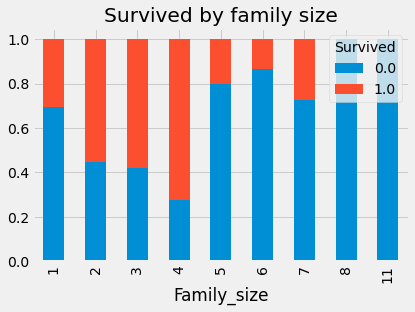

In [159]:
pd.crosstab(full_df['Family_size'], full_df['Survived'], normalize='index').plot(kind='bar', stacked=True, title="Survived by family size")

In [160]:
pd.crosstab(full_df['Family_size'], full_df['Survived'], normalize='index')

Survived,0.0,1.0
Family_size,,
1,0.695167,0.304833
2,0.447205,0.552795
3,0.421569,0.578431
4,0.275862,0.724138
5,0.800000,0.200000
6,0.863636,0.136364
7,0.727273,0.272727
8,1.000000,0.000000
11,1.000000,0.000000


In [161]:
families_not_sharing_ticket = full_df[(full_df.Family_size !=1) & (full_df.Ticket_group_size == 1)]
print("{} passengers accompanied by family members did not share the tickets".format(len(families_not_sharing_ticket)))
print('5 among them:')
families_not_sharing_ticket.head()

48 passengers accompanied by family members did not share the tickets
5 among them:


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Fare_mean,Is_female,Cabin_quantity,Cabin_null,Age_null,Title,Title_group,Family_size,Family_name,Family_name_size
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,...,7.2500,0,1,True,False,Mr,male adult,2,Braund,2
40,41,0.0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",40.0,1,0,7546,9.4750,NaN,...,9.4750,1,1,True,False,Mrs,married woman,2,Ahlin,1
69,70,0.0,3,"Kink, Mr. Vincenz",26.0,2,0,315151,8.6625,NaN,...,8.6625,0,1,True,False,Mr,male adult,3,Kink,2
104,105,0.0,3,"Gustafsson, Mr. Anders Vilhelm",37.0,2,0,3101276,7.9250,NaN,...,7.9250,0,1,True,False,Mr,male adult,3,Gustafsson,4
113,114,0.0,3,"Jussila, Miss. Katriina",20.0,1,0,4136,9.8250,NaN,...,9.8250,1,1,True,False,Miss,girl or unmarried woman,2,Jussila,3


In [162]:
#obtain the number of companions who are not family members

